In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi, isnan, isinf
from scipy.optimize import minimize
from scipy.linalg import inv
from scipy import stats

# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


In [2]:
# params : [mu, theta, omega_2, alpha, beta, m]
def beta_lag_wt_scheme(K, omega_2, omega_1 = 1):
    '''
    Function to generate an array of factor weights phis
    Args:
        K (int) : the number of lags.
        omega_1 (float, optional) : The first parameter of the weighting scheme. Defaults to 1.
        omega_2 (float) : The second parameter of the weighting scheme.

    Returns:
        ndarray: A column vector representing the weighting scheme.

    '''
    j_vec = np.arange(K,0,-1)
    denom =\
    (
        np
        .sum(
            (j_vec/(K+1)) ** (omega_1 - 1.0)
            * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
        )
    )

    numer =\
    (
        (j_vec/(K+1)) ** (omega_1 - 1.0)
        * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
    )

    return (numer / denom).reshape(j_vec.shape[0],1)
    
def get_onefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on one-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 6 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta, omega, m = params
    
    tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    T = tau.size

    return mu, alpha, beta, tau, T

def get_twofactor_tau(params, X, K):
    '''
    Function to return an array of taus based on two-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 8 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2, omega1, omega2, m = params
    X1, X2 = X
    #log_tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    tau =\
    (
        m**2 
        + theta1**2 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2**2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
    )
    T = tau.size

    return mu, alpha, beta, tau, T

def get_threefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on three-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 10 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2,theta3, omega1, omega2, omega3, m = params
    X1, X2, X3 = X
    #log_tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    tau =\
    (
        m**2 
        + theta1**2 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2**2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
        + theta3**2 * np.dot(X3, beta_lag_wt_scheme(K, omega3))
    )
    T = tau.size

    return mu, alpha, beta, tau, T


def GARCH_MIDAS(params, returns, X, K, get_tau = get_onefactor_tau, full_output = False):
    '''
    Function representing the GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the parameters required for the model
        X (ndarray or tuple) : A set of matrices of the factor values. If there are more than one factor, a tuple is used.
        K (int) : The number of lags.
        get_tau (obj, optional) : The function required to get the required tau array. Defaults to one factor model, get_onefactor_tau
        full_output (bool, optional) : If True, it returns a set of outputs -loglik, logliks, e, tau, gt, ht, T. Otherwise, returns loglik. Defaults to False.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''

    mu, alpha, beta, tau, T = get_tau(params, X, K)

    ## define the squared errors
    e = returns[-tau.shape[0]:] - mu
    e2 = e**2
    e2 = e2.flatten()

    # define g
    gt = np.array([tau[0]])

    for t in range(1, tau.size):
        
        gt =\
            np.append(gt, 
                      (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
    
    gt = gt.reshape(-1,1)
    ht = np.multiply(tau,gt).flatten()

    # log likelihood
    logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
    
    if isnan(logliks.sum()) or isinf(logliks.sum()):
        loglik = 1E10
    else:
        loglik = logliks.sum()

    
    if full_output == True:
        return -loglik, logliks, e, tau, gt, ht, T

    else:
        return loglik



In [3]:
def hessian_matrix(fun, theta, args, epsilon=1e-05):
    '''
    Function to calculate the hessian matrix of the model.

    '''
    f = fun(theta, *args)
    h_ = epsilon*np.abs(theta)
    
    h = np.diag(h_)
    K = theta.shape[0]
    
    fp = np.zeros(K)
    fm = np.zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        
    fpp = np.zeros((K,K))
    fmm = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j],  *args)
            fmm[j,i] = fmm[i,j]
            
    hh = (np.diag(h))
    hh = hh.reshape((K,1))
    hh = np.dot(hh,hh.T)
    
    H = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

def summary_stats(fun, T, params, args, labels, epsilon=1e-05):
    '''
    Function to calculate the p-values of the parameters given the model.

    '''
    H = hessian_matrix(fun, params, args, epsilon = epsilon)
    vcv = inv(H/T)/T
    se = np.diag(vcv)**0.5
    t = params/se
    pvalues = stats.t.sf(np.abs(t),args[0].size - params.shape[0])

    df =\
    (
        pd
        .DataFrame(
            data = {'values': params, 
                    'p-val': pvalues}, 
            index = labels
            ).T
    )

    return df

    


---

# Data Processing
- Read csvs containing CPU, EMDAT, Futures data

In [4]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('../data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('../data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('../data/natgas_futures_price.csv', sep=',')

In [5]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%d/%m/%y')
natgas_futures.set_index('Date', inplace=True)
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1994-01-14,2.268,3.317202,1994-01,56.733087,22
1994-01-17,2.360,3.976323,1994-01,56.733087,22
1994-01-18,2.318,-1.795687,1994-01,56.733087,22
1994-01-19,2.252,-2.888603,1994-01,56.733087,22
1994-01-20,2.250,-0.088849,1994-01,56.733087,22


In [6]:
def get_realized_variance(data, target):
    factor =\
    (
        data[[target]]
        .resample('M')
        .agg(lambda x: (x ** 2).sum())
        .rename(columns = {target : 'realized_variance'})
    ).iloc[1:]

    return factor

def get_factors(data, target, K, fun = None):
    '''
    Function to derive the factor values required.

    Args:
        data (DataFrame) : The dataframe containing the original data.
        target (string) : The name of the target factor.
        K (int) : The number of lags.
        fun (obj, optional) : The function to use to derive the factor values. Defaults to None

    returns:
        ndarray : The derived matrix of factor values.
    '''
    if fun:
        factor = fun(data, target)
        target = 'realized_variance'

    else:
        factor =\
        (
            data[[target]]
            .resample('M')
            .mean()
        ).iloc[1:]

    for i in range(1,K+1):
        factor[f'{target}_lag_{str(i).zfill(2)}'] =\
            factor[f'{target}'].shift(i)
        
    factor.dropna(inplace = True)
    factor['YYYY-MM'] = factor.index.to_period('M')

    X =\
    (
        np.array(
            data[['YYYY-MM']]
            .merge(factor,
                how = 'left',
                on = 'YYYY-MM')
            .dropna()
            .iloc[:,:1:-1]
        )
    )

    return X

---
## One-factor GARCH-MIDAS 

### Model 1: Realized Variance

In [7]:
X1 = get_factors(data, 'daily_return', 36, fun = get_realized_variance)

In [8]:
## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 1, -2])

returns = np.array(data[['daily_return']])

# method='L-BFGS-B', \
results = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (returns, X1, 36)) ## Limited Memory BFGS

results

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\3946848200.py:82: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17573.5278359954
        x: [ 3.980e-02  7.663e-02  9.052e-01  2.117e-01 -1.877e-01
            -1.178e+00]
      nit: 45
      jac: [ 1.117e-01 -1.392e+00 -1.148e+00  4.282e-01  3.893e-02
            -2.219e-02]
     nfev: 399
     njev: 57
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

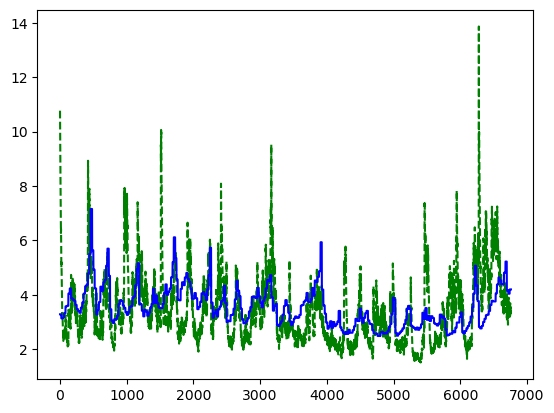

In [9]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results['x'], returns, X1, 36, full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [10]:
summary_stats(GARCH_MIDAS, 
              T, 
              results['x'], 
              (returns, X1, 36), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])

,mu,alpha,beta,theta,omega,m
values,0.039801,7.662596e-02,0.905184,2.116667e-01,-0.187664,-1.178429
p-val,0.126474,8.629669e-40,0.000000,1.332789e-29,0.092482,0.048828


---
## Two-factors GARCH-MIDAS

In [11]:
X2 = get_factors(data, 'cpu_index', 36)
X3 = get_factors(data, 'Monthly_Disaster_Freq', 36)

Model 2: RV + CPU

In [12]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

# method='L-BFGS-B', \
results2 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (returns, (X1, X2), 36, get_twofactor_tau)) ## Limited Memory BFGS

results2

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\3946848200.py:82: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17573.2376342601
        x: [ 3.979e-02  7.671e-02  9.051e-01  2.136e-01  1.081e-01
            -1.800e-01  9.957e-01 -1.098e-01]
      nit: 68
      jac: [ 3.147e-01 -1.496e+00 -7.974e-01  7.494e-02  2.023e-01
            -2.037e-02 -1.492e-01 -1.019e-02]
     nfev: 738
     njev: 82
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

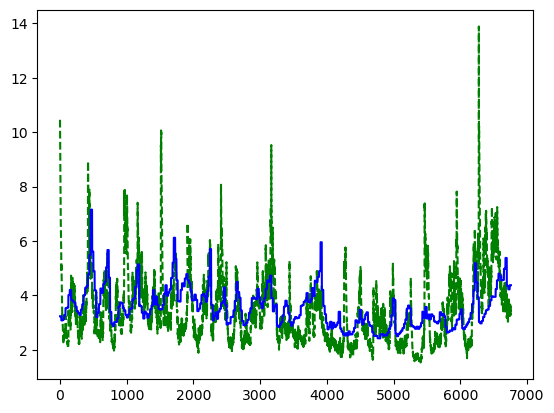

In [13]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results2['x'], returns, (X1, X2), 36, get_tau=get_twofactor_tau, full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [14]:
summary_stats(GARCH_MIDAS, 
              T, 
              results2['x'], 
              (returns, (X1, X2), 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\2236944991.py:39: RuntimeWarning: invalid value encountered in sqrt
  se = np.diag(vcv)**0.5


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.039795,7.671442e-02,0.905053,2.135750e-01,0.108054,-0.179981,0.995726,-0.109787
p-val,0.124766,8.909618e-40,0.000000,8.804416e-58,0.013065,0.060686,NaN,0.436746


Model 3: RV + EMDAT

In [15]:
# method='L-BFGS-B', \
results3 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (returns, (X1, X3), 36, get_twofactor_tau)) ## Limited Memory BFGS

results3

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\3946848200.py:82: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17563.91457661466
        x: [ 3.792e-02  7.435e-02  9.079e-01  1.672e-01 -4.595e-01
            -4.805e-01  1.841e+01  4.809e-04]
      nit: 124
      jac: [ 1.342e-01  2.001e-02 -1.290e+00  1.019e-01 -2.023e-01
             8.768e-02 -7.276e-04  1.455e-03]
     nfev: 1278
     njev: 142
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

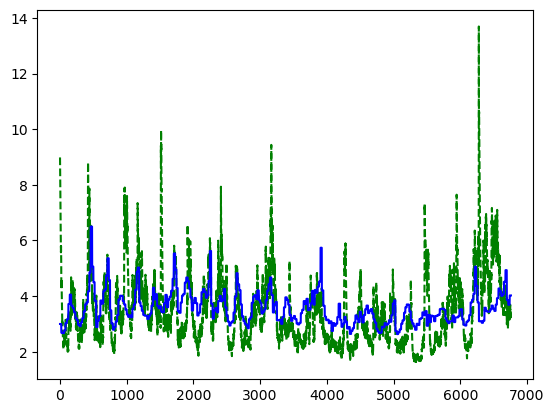

In [16]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results3['x'], returns, (X1, X3), 36, get_tau=get_twofactor_tau, full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [17]:
summary_stats(GARCH_MIDAS, 
              T, 
              results3['x'], 
              (returns, (X1, X3), 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\2236944991.py:39: RuntimeWarning: invalid value encountered in sqrt
  se = np.diag(vcv)**0.5


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.037920,7.434664e-02,0.907858,1.672323e-01,-4.594677e-01,-0.480510,18.411563,0.000481
p-val,0.137824,5.692540e-38,0.000000,7.103602e-21,1.536950e-14,0.009822,0.012833,NaN


---
## Three-Factors GARCH-MIDAS
Model 4: RV + CPU + EMDAT, K = 36

In [18]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, omega1, omega2, omega3, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results4 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (returns, (X1, X2, X3), 
                          36, get_threefactor_tau)) ## Limited Memory BFGS

results4

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\3946848200.py:82: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17563.915282736805
        x: [ 3.723e-02  7.431e-02  9.079e-01  1.669e-01 -1.446e-03
            -4.605e-01 -4.825e-01  9.984e-01  1.848e+01 -4.920e-03]
      nit: 176
      jac: [-4.442e-01  1.903e+00  1.175e+00 -9.601e-01 -4.668e-01
            -3.627e-01  1.051e-01  3.638e-04  1.455e-03 -1.492e-02]
     nfev: 2310
     njev: 210
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

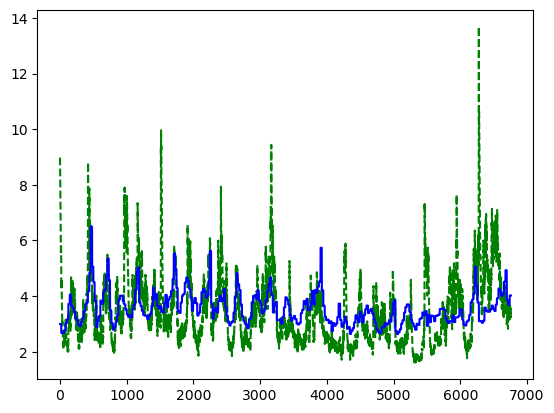

In [19]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results4['x'], returns, (X1, X2, X3), 36, get_tau=get_threefactor_tau, full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [20]:
summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (returns, (X1,X2,  X3), 36, get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\2236944991.py:39: RuntimeWarning: invalid value encountered in sqrt
  se = np.diag(vcv)**0.5


,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.037227,7.430547e-02,0.907927,1.669063e-01,-0.001446,-4.604997e-01,-0.482508,0.998357,18.476447,-0.00492
p-val,0.140529,5.525649e-38,0.000000,1.111486e-20,NaN,1.436803e-14,0.010027,NaN,0.013185,NaN


Model 5: RV + CPU + EMDAT, K = 33

In [21]:
X1_3fac = get_factors(data, 'daily_return', 33, fun = get_realized_variance)
X2_3fac = get_factors(data, 'cpu_index', 33)
X3_3fac = get_factors(data, 'Monthly_Disaster_Freq', 33)

In [22]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results5 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (returns, (X1_3fac, X2_3fac, X3_3fac), 
                          33, get_threefactor_tau)) ## Limited Memory BFGS

results5

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\3946848200.py:82: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17794.760737290788
        x: [ 3.365e-02  7.720e-02  9.109e-01  6.197e-02 -2.681e-04
             6.899e-01 -6.122e+00  9.837e-01  4.028e+00  8.814e-01]
      nit: 85
      jac: [ 7.785e-02 -1.441e+00 -7.298e-01  2.467e-01 -6.767e-02
             1.492e-01 -2.256e-02  0.000e+00 -1.233e+00  1.215e+00]
     nfev: 1078
     njev: 98
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

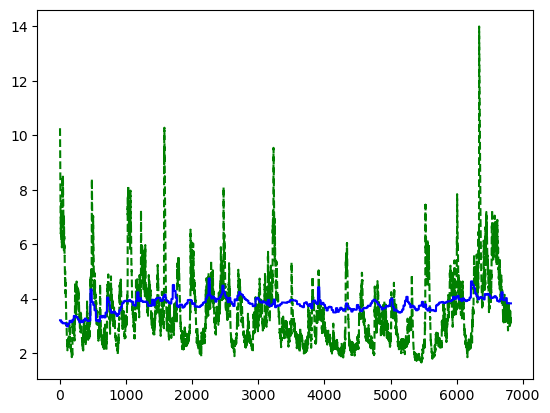

In [23]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results5['x'], 
                                                  returns, 
                                                  (X1_3fac, X2_3fac, X3_3fac), 
                                                  33, 
                                                  get_tau=get_threefactor_tau, 
                                                  full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [24]:
summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (returns, (X1_3fac, X2_3fac,  X3_3fac), 
              33, 
              get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

C:\Users\leeca\AppData\Local\Temp\ipykernel_8268\2236944991.py:39: RuntimeWarning: invalid value encountered in sqrt
  se = np.diag(vcv)**0.5


,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.037227,7.430547e-02,0.907927,1.669063e-01,-0.001446,-0.4605,-0.482508,0.998357,18.476447,-0.004920
p-val,0.150282,4.030737e-47,0.000000,6.744787e-176,0.462672,NaN,NaN,0.394379,0.001329,0.106293


---